In [1]:
import os
os.chdir("/Users/User/P2")
print(os.getcwd())

C:\Users\User\P2


In [2]:
import pandas as pd
import numpy as np 

#load the data
data = pd.read_csv('PK_chl_nn-cleaned.csv')
print(data.shape)
print(data.info())

(1640, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1640 non-null   object 
 1   PK_chl_nn  1640 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.8+ KB
None


In [3]:
# ADF Test = testing if data is stationary

from statsmodels.tsa.stattools import adfuller

result = adfuller(data['PK_chl_nn'])

def adfuller_test(PK_chl_nn):
    result=adfuller(PK_chl_nn)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(data['PK_chl_nn'])

strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary
ADF Test Statistic : -6.370285380006379
p-value : 2.3542820773687838e-08
#Lags Used : 10
Number of Observations : 1629


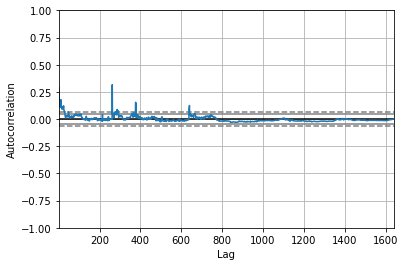

In [4]:
#autocorrelation

from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline

autocorrelation_plot(data['PK_chl_nn'])
plt.show()

In [5]:
#divide into train and validation set
train = data[:int(0.7*(len(data)))]
valid = data[int(0.7*(len(data))):]

#preprocessing (since arima takes univariate series as input)
train.drop('Date',axis=1,inplace=True)
valid.drop('Date',axis=1,inplace=True)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


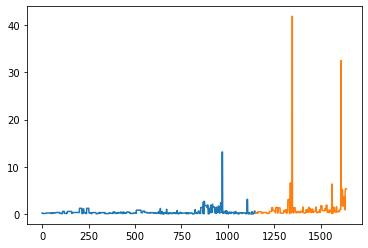

In [6]:
#plotting the data

train['PK_chl_nn'].plot()
valid['PK_chl_nn'].plot()

In [7]:
#building the model (with optimal p,d,q value)
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model_fit=model.fit(train)

model_fit


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1903.475, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2087.633, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2087.649, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2087.534, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2085.633, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1899.464, Time=0.81 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2064.163, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1911.477, Time=0.70 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1740.881, Time=0.70 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1743.688, Time=0.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1742.753, Time=0.80 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1742.791, Time=1.42 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1740.791, Time=1.01 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1742.791, Time=0.91 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept

ARIMA(order=(0, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [8]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

In [9]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1148
Model:               SARIMAX(0, 1, 4)   Log Likelihood                -864.398
Date:                Tue, 18 Jan 2022   AIC                           1738.797
Time:                        00:57:04   BIC                           1764.021
Sample:                             0   HQIC                          1748.320
                               - 1148                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1734      0.009    -19.800      0.000      -0.191      -0.156
ma.L2         -0.1139      0.012     -9.563      0.000      -0.137      -0.091
ma.L3         -0.5562      0.007    -81.079      0.000      -0.570      -0.543
ma.L4         -0.0671      0.013     -5.083      0.000      -0.093      -0.041
sigma2         0.2638      0.001    226.860      0.000       0.262       0.266
===================================================================================
Ljung-Box (Q):                       37.59   Jarque-Bera (JB):           4867232.16
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):              32.81   Skew:                            11.82
Prob(H) (two-sided):                  0.00   Kurtosis:                       321.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

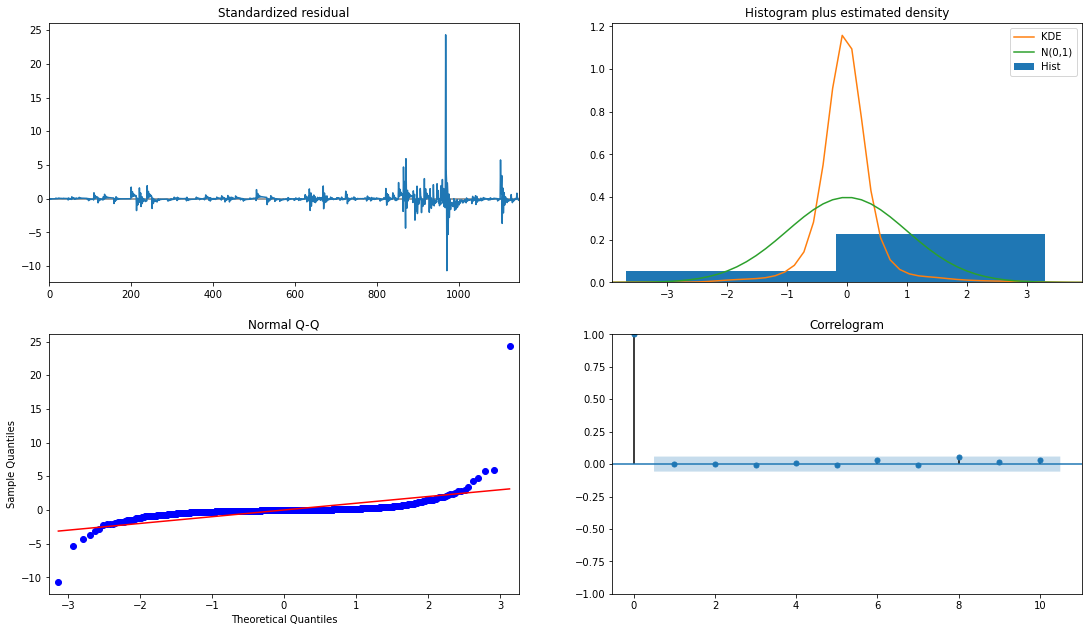

In [10]:
fig = model_fit.plot_diagnostics()
fig.set_size_inches(18.5, 10.5)

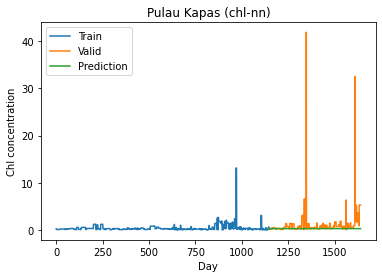

In [11]:
#plot the predictions for validation set

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.xlabel("Day")
plt.ylabel("Chl concentration")
plt.legend(loc="upper left")
plt.title("Pulau Kapas (chl-nn)")
plt.show()

In [12]:
#model evaluation
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import r2_score


print('Mean Absolute Error:', metrics.mean_absolute_error(valid,forecast))
print('Mean Squared Error:', metrics.mean_squared_error(valid,forecast))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(valid,forecast)))
print('R Squared value:',r2_score(valid,forecast))

Mean Absolute Error: 0.7915910087880808
Mean Squared Error: 7.2094225559446805
Root Mean Squared Error: 2.6850367885644846
R Squared value: -0.08561424117272476
